In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import re

# Load Dataset

In [2]:
# dataset diambil dari https://github.com/robsalgado/personal_data_science_projects/tree/master/mulitclass_text_class
df = pd.read_csv("df.csv",dtype=object)
df.head()

,content,label
0,Unions representing workers at Turner Newall...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech
2,AP - A company founded by a chemistry research...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech
4,AP - Southern California's smog-fighting agenc...,SciTech


# One Hot Endocder for label data

In [3]:
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='label')

df_baru['content'] = df_baru['content'].replace('\n', ' ').str.lower()

def fun(x):
    y = re.sub(r'[^a-zA-Z0-9. ]', '', x)
    return y

df_baru['content'] = df_baru['content'].apply(lambda x : fun(x))

df_baru['content'] = df_baru['content'].replace('   ', ' ')
df_baru['content'] = df_baru['content'].replace('  ', ' ')



df_baru.head()

,content,Business,SciTech,Sports,World
0,unions representing workers at turner newall...,1,0,0,0
1,space.com toronto canada a secondteam of roc...,0,1,0,0
2,ap a company founded by a chemistry researche...,0,1,0,0
3,ap its barely dawn when mike fitzpatrick star...,0,1,0,0
4,ap southern californias smogfighting agency w...,0,1,0,0


# Split x y

In [4]:
x = df_baru['content'].values
y = df_baru[['Business', 'SciTech', 'Sports', 'World']].values

# Tokenizer

In [5]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(x)

In [6]:
sekuens_x = tokenizer.texts_to_sequences(x)

# Padding

In [7]:
padded_x = pad_sequences(sekuens_x) 

# Split train test val

In [8]:
x_train, x_test, y_train, y_test = train_test_split(padded_x, y, test_size=0.2, random_state = 4)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 4)

# Calls the function model to be used 

https://towardsdatascience.com/machine-learning-model-regularization-in-practice-an-example-with-keras-and-tensorflow-2-0-52a96746123e

https://towardsdatascience.com/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f

https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=128),
    
    tf.keras.layers.LSTM(128),
        
    tf.keras.layers.Dense(128, kernel_regularizer=L1L2(l1=0.01, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(128, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(128, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(128, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(128, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),    
    
    tf.keras.layers.Dense(4, activation='softmax')
])

# Call EarlyStopping

In [10]:
# early_stop = EarlyStopping(monitor='val_categorical_accuracy', baseline = 0.75, restore_best_weights = True)

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_categorical_accuracy') > 0.80 ):
            self.model.stop_training = True

callbacks = myCallback()

# Call optimizer for model

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])

# Train the data

In [13]:
%%time
num_epochs = 1000
fit = model.fit(x_train, 
                y_train, 
#                 batch_size = 16,
                epochs=num_epochs, 
                validation_data=(x_val, y_val),
#                 validation_split=0.2,       
                callbacks = [callbacks]
)

Epoch 1/1000
152/152 [==============================] - 15s 87ms/step - loss: 15.7201 - categorical_accuracy: 0.3335 - val_loss: 10.9382 - val_categorical_accuracy: 0.2459
Epoch 2/1000
152/152 [==============================] - 13s 84ms/step - loss: 7.5542 - categorical_accuracy: 0.5718 - val_loss: 5.6686 - val_categorical_accuracy: 0.2566
Epoch 3/1000
152/152 [==============================] - 11s 75ms/step - loss: 3.7374 - categorical_accuracy: 0.7965 - val_loss: 3.5739 - val_categorical_accuracy: 0.2895
Epoch 4/1000
152/152 [==============================] - 12s 77ms/step - loss: 2.3155 - categorical_accuracy: 0.8542 - val_loss: 2.4372 - val_categorical_accuracy: 0.6867
Epoch 5/1000
152/152 [==============================] - 12s 81ms/step - loss: 1.5970 - categorical_accuracy: 0.8966 - val_loss: 1.6793 - val_categorical_accuracy: 0.7829
Epoch 6/1000
152/152 [==============================] - 14s 94ms/step - loss: 1.0915 - categorical_accuracy: 0.9305 - val_loss: 1.3791 - val_categor

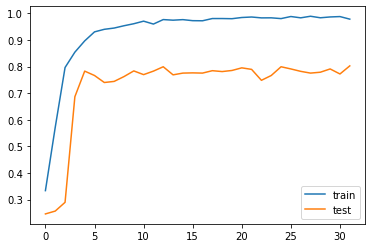

In [14]:
plt.plot(fit.history['categorical_accuracy'], label='train')
plt.plot(fit.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show()

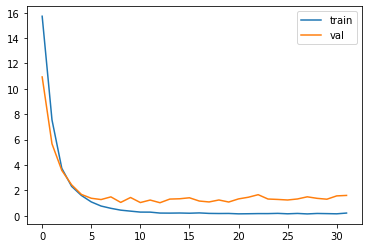

In [15]:
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='val')
plt.legend()
plt.show()

In [16]:
train_loss, train_acc = model.evaluate(x_train, y_train, steps=16)
val_loss, val_acc = model.evaluate(x_val, y_val, steps=16)
test_loss, test_acc = model.evaluate(x_test, y_test, steps=16)

print('\nTrain: %.3f, val: %.3f, test: %.3f,' % (train_acc, val_acc, test_acc))

16/16 [==============================] - 2s 98ms/step - loss: 1.7530 - categorical_accuracy: 0.7855

Train: 0.983, val: 0.803, test: 0.786,


# Save Model

In [17]:
filename = 'lstm.h5'
model.save(filename)

In [18]:
import io
import json

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))